In [2]:
import gpflow as gpf
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from cpgp.segcpgp import SegCPGP as NormalSegCPGP
from cpgp.segcpgp_sparse import SegCPGP as FastSegCPGP
from cpgp.segcpgp_robust import SegCPGP as RobustSegCPGP
import json
import time

2025-05-20 13:25:42.109874: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 13:25:42.114835: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 13:25:42.173921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 13:25:42.174010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 13:25:42.176724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
def plot_result(X, y, segcpgp, ci):
    plt.figure(figsize=(24, 3))
    plt.plot(X, y)
    plt.scatter(ci, np.zeros_like(ci), marker="^", color="r")
    for loc in segcpgp.LOCS:
        plt.axvline(loc, color="r")
        
    with open("/home/janneke/changepoint-gp/TCPD/annotations.json") as f:
        annot = json.load(f)
    for annotation in annot["well_log"]: 
        print(annot["well_log"], sorted(segcpgp.LOCS))
    plt.show()

In [4]:
def plot_model(model: gpf.models.GPModel) -> None:
    X, Y = model.data
    opt = gpf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    gpf.utilities.print_summary(model, "notebook")

    Xplot = np.linspace(0.0, 200, 200)[:, None]

    y_mean, y_var = model.predict_y(Xplot, full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    _, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(X, Y, "kx", mew=2)
    (mean_line,) = ax.plot(Xplot, y_mean, "-")
    color = mean_line.get_color()
    ax.plot(Xplot, y_lower, lw=0.1, color=color)
    ax.plot(Xplot, y_upper, lw=0.1, color=color)
    ax.fill_between(
        Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color=color, alpha=0.1
    )

    # Also plot the inducing variables if possible:
    iv = getattr(model, "inducing_variable", None)
    if iv is not None:
        ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")

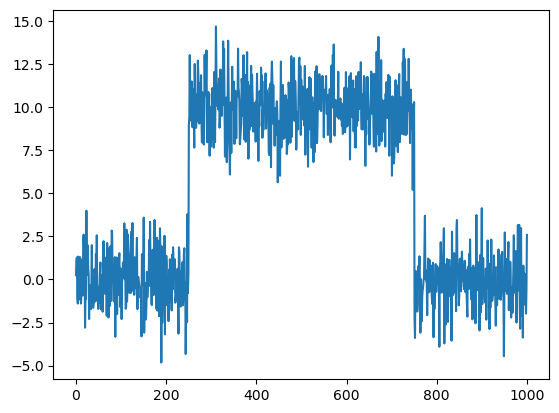

In [5]:
X = np.linspace(0, 1000, 1000).reshape(-1, 1).astype(float)
#y = np.sin(0.05*X)**2
y = np.random.normal(0, 1.5, size=len(X)).reshape(-1, 1)
ci = np.array((250, 750))

y[ci[0]:ci[1]] += 10


plt.plot(X, y)


0.0 1000.0
p 1.0 df 3 location [430.99234819] steepness [0.97756489]
6.358018398284912
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 25

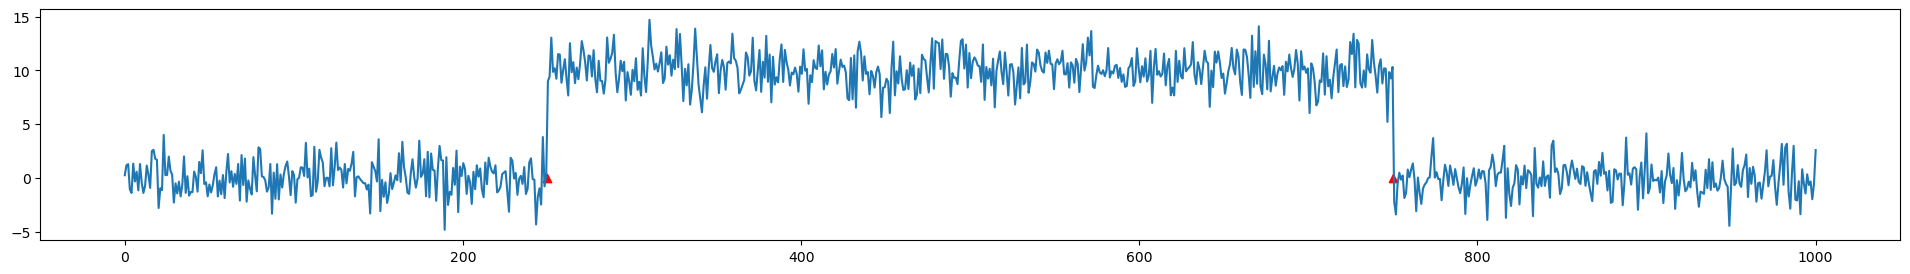

In [5]:
segcpgp = FastSegCPGP(n_ind=50)
dt = time.time()
segcpgp.fit(X, y, "noise")
print(time.time() - dt)
plot_result(X, y, segcpgp, ci)

0.0 1000.0
5.528866557908738e-81 3
p 5.528866557908738e-81 df 3 bic tf.Tensor(177.17821019842052, shape=(), dtype=float64) location [750.71827634] steepness [846.64527818]
0.0 744.7447447447448
0.0 3
p 0.0 df 3 bic tf.Tensor(859.4233235790238, shape=(), dtype=float64) location [249.86333202] steepness [5.62409496]
0.0 243.24324324324326
1.0 3
p 1.0 df 3 bic tf.Tensor(-8.245752340246735, shape=(), dtype=float64) location [213.83463169] steepness [0.0782044]
254.25425425425428 744.7447447447448
1.0 3
p 1.0 df 3 bic tf.Tensor(-9.294666199568686, shape=(), dtype=float64) location [232.19463918] steepness [1.62053677e-41]
755.7557557557558 1000.0
0.9939089806109243 3
p 0.9939089806109243 df 3 bic tf.Tensor(-8.21089953572157, shape=(), dtype=float64) location [806.32218688] steepness [24.27476211]
96.4184262752533
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 4

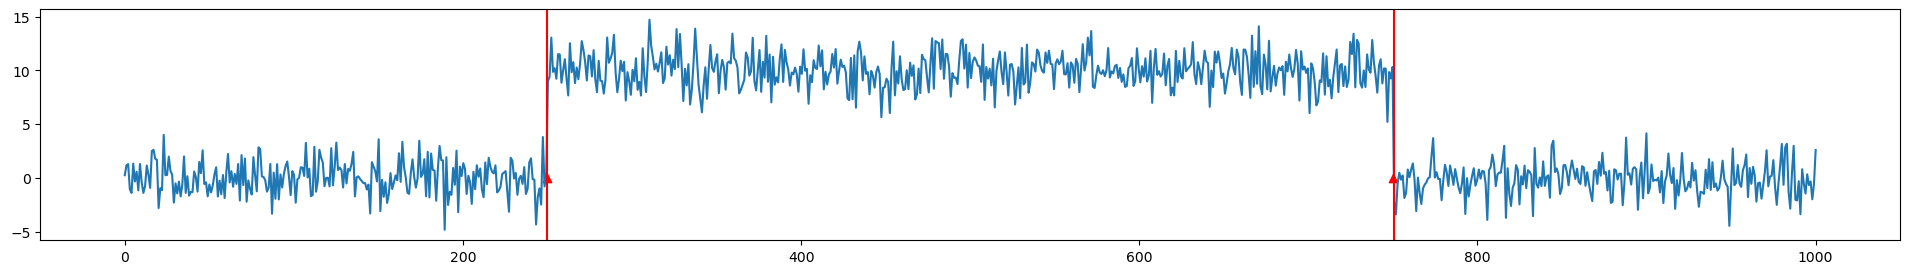

In [7]:
segcpgp = NormalSegCPGP()
dt = time.time()
segcpgp.fit(X, y, "constant")
print(time.time() - dt)
plot_result(X, y, segcpgp, ci)

In [9]:
segcpgp = RobustSegCPGP()
dt = time.time()
segcpgp.fit(X, y, "constant")
print(time.time() - dt)
plot_result(X, y, segcpgp, ci)

0.0 1000.0


KeyboardInterrupt: 

{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []


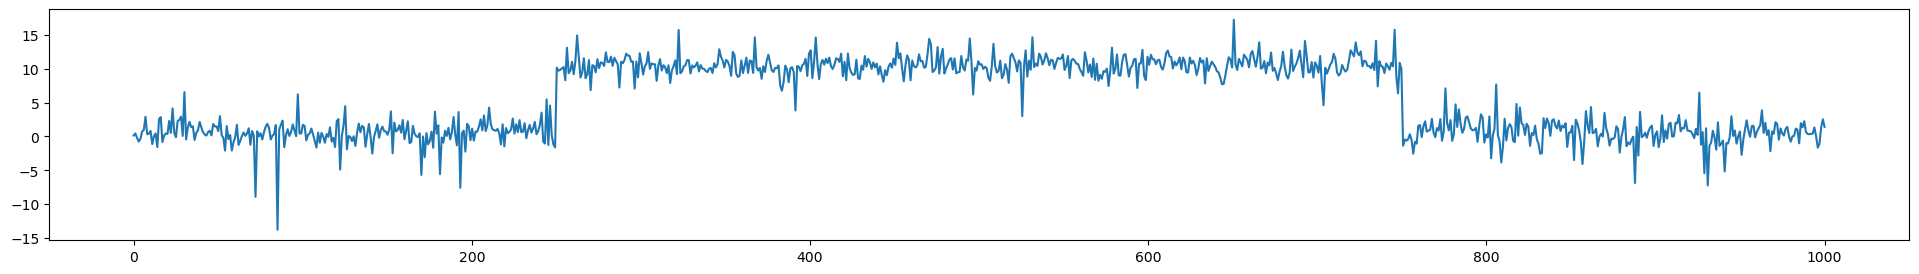

In [ ]:
plt.figure(figsize=(24, 3))
plt.plot(X, y)
for loc in segcpgp.LOCS:
    plt.axvline(loc, color="r")
    
with open("/home/janneke/changepoint-gp/TCPD/annotations.json") as f:
    annot = json.load(f)
print(annot["well_log"], sorted(segcpgp.LOCS))

NameError: name 'SegCPGP' is not defined

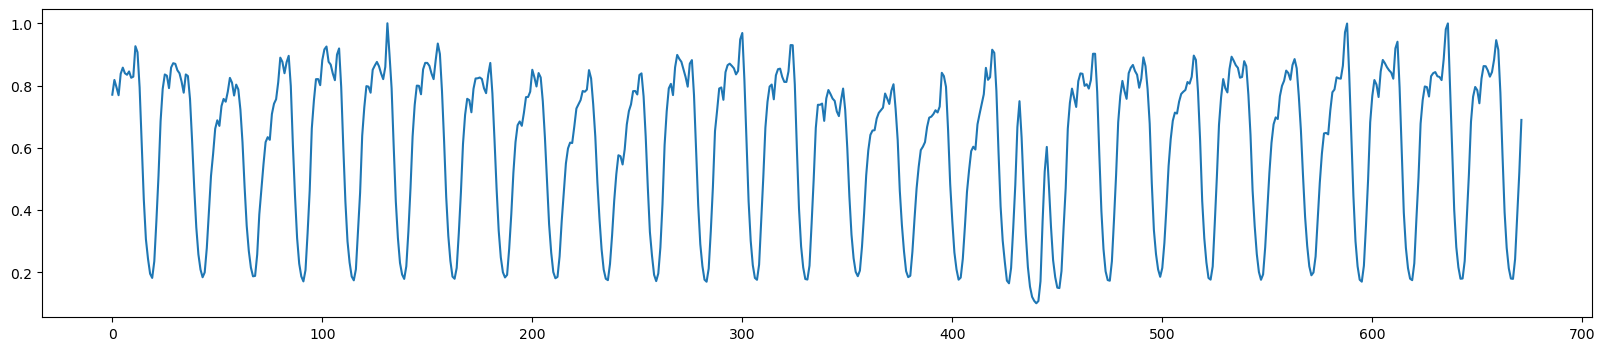

In [ ]:
path = "/home/janneke/Downloads/cloudflare-radar_get-http-timeseries_20250508.json"    

with open(path) as f:
    data = json.load(f)
    
X = data["result"]["main"]["timestamps"]
y = data["result"]["main"]["values"]
plt.figure(figsize=(20, 4))
X = np.arange(len(y)).astype(float).reshape(-1, 1)
y = np.array(y).astype(float).reshape(-1, 1)
plt.plot(y)

segcpgp = SegCPGP()
segcpgp.fit(X, y, "spectral-5")
for loc in segcpgp.LOCS:
    plt.axvline(loc, color="r")
plt.show()

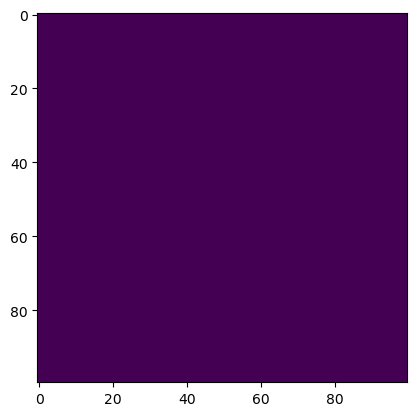

In [ ]:
k = gpf.kernels.Constant(1)
X = np.arange(0, 100).reshape(-1, 1)
plt.imshow(k(X))

In [6]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("nikitamanaenkov/stock-portfolio-data-with-prices-and-indices")

print("Path to dataset files:", path)


Path to dataset files: /home/janneke/.cache/kagglehub/datasets/nikitamanaenkov/stock-portfolio-data-with-prices-and-indices/versions/1


Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adjusted', 'Returns',
       'Volume'],
      dtype='object')


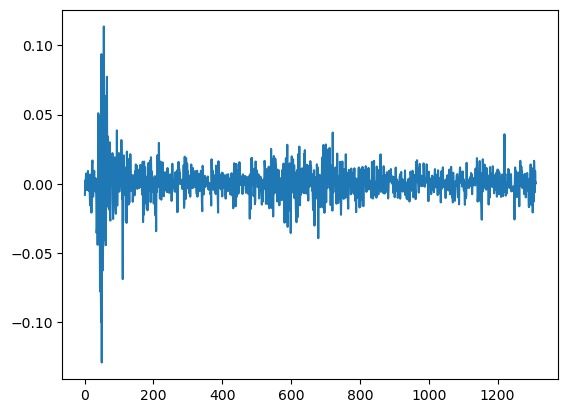

In [15]:
df = pd.read_csv(path+"/Dow_Jones.csv")
print(df.columns)
y = df["Returns"].to_numpy().reshape(-1, 1)
X = np.arange(len(y)).reshape(-1, 1).astype(float)

plt.plot(X, y)

0.0 1311.0
p nan df 3 location [1128.] steepness [1.]
5.168985605239868
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} []
{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 34

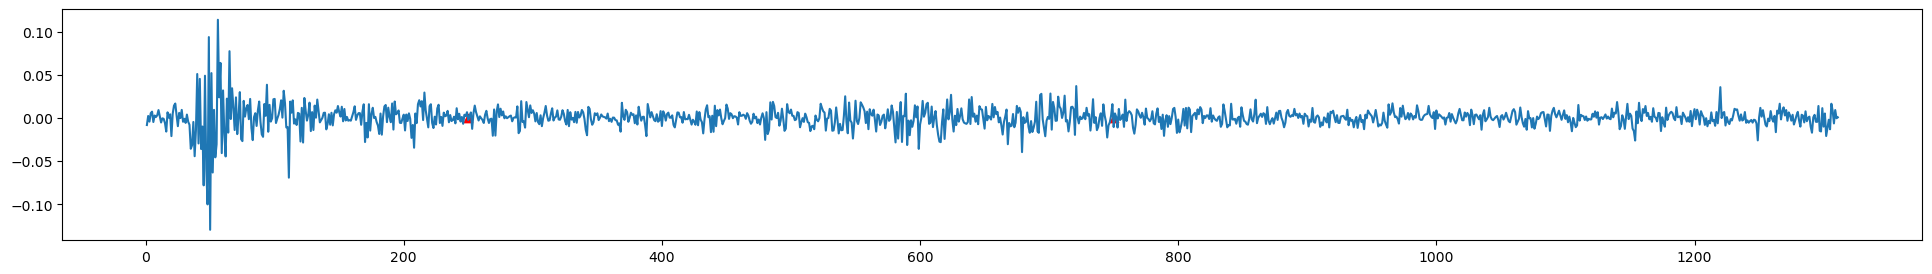

In [16]:
segcpgp = FastSegCPGP(n_ind=50)
dt = time.time()
segcpgp.fit(X, y, "noise")
print(time.time() - dt)
plot_result(X, y, segcpgp, ci)